## MEV Analysis for Ethereum Foundation Research Challenge

I am gonna do sample problem analysis for MEV using data from Ethereum blocks 23300000-23300500.

In [1]:
import pandas as pd

In [ ]:
df0 = pd.read_csv("data/transactions0-50.csv")
df1 = pd.read_csv("data/transactions51-100.csv")
df2 = pd.read_csv("data/transactions101-200.csv")
df3 = pd.read_csv("data/transactions201-300.csv")
df4 = pd.read_csv("data/transactions301-400.csv")
df5 = pd.read_csv("data/transactions401-500.csv")

df = pd.concat([df0, df1, df2, df3, df4, df5])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103961 entries, 0 to 19735
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   hash                      103961 non-null  object 
 1   nonce                     103961 non-null  int64  
 2   block_hash                103961 non-null  object 
 3   block_number              103961 non-null  int64  
 4   transaction_index         103961 non-null  int64  
 5   from_address              103961 non-null  object 
 6   to_address                103786 non-null  object 
 7   value                     103961 non-null  object 
 8   gas                       103961 non-null  int64  
 9   gas_price                 103961 non-null  int64  
 10  input                     103961 non-null  object 
 11  block_timestamp           103961 non-null  int64  
 12  max_fee_per_gas           88490 non-null   float64
 13  max_priority_fee_per_gas  88490 non-null   float64

| Column                     | Explanation                                                                            |
| -------------------------- | -------------------------------------------------------------------------------------- |
| `hash`                     | Unique identifier of the transaction.                                                  |
| `nonce`                    | Sender’s transaction count (used to prevent replay).                                   |
| `block_hash`               | Identifier of the block containing this transaction.                                   |
| `block_number`             | Number of the block in the blockchain.                                                 |
| `transaction_index`        | Order of the transaction within the block.                                             |
| `from_address`             | Ethereum address sending the transaction.                                              |
| `to_address`               | Ethereum address receiving the transaction (or contract called).                       |
| `value`                    | Amount of ETH (in wei) transferred. Stored as string.                                  |
| `gas`                      | Gas limit set by the sender. Maximum computational effort allowed.                     |
| `gas_price`                | Legacy gas price (wei per unit of gas) for type 0 transactions.                        |
| `input`                    | Encoded data for smart contract calls or arbitrary input.                              |
| `block_timestamp`          | Unix timestamp of when the block was mined.                                            |
| `max_fee_per_gas`          | Maximum total fee per gas unit the sender is willing to pay (EIP-1559).                |
| `max_priority_fee_per_gas` | Miner tip per gas unit to prioritize transaction (EIP-1559).                           |
| `transaction_type`         | Type of transaction: 0 = legacy, 2 = EIP-1559.                                         |
| `max_fee_per_blob_gas`     | Max fee per “blob” (related to Ethereum’s EIP-4844 / Proto-Danksharding). Mostly null. |
| `blob_versioned_hashes`    | Hash of data blob(s) included in the transaction. Mostly null.                         |


In [4]:
df.drop(columns=["max_fee_per_blob_gas"], inplace=True)
df.drop(columns=["blob_versioned_hashes"], inplace=True)

df = df.sort_values(["block_number", "transaction_index"])

In [5]:
df["value"] = df["value"].astype(float)  # ETH in wei
df["gas"] = df["gas"].astype(float)
df["gas_price"] = pd.to_numeric(df["gas_price"], errors="coerce")
df["max_fee_per_gas"] = pd.to_numeric(df["max_fee_per_gas"], errors="coerce")
df["max_priority_fee_per_gas"] = pd.to_numeric(
    df["max_priority_fee_per_gas"], errors="coerce"
)
df["block_timestamp"] = pd.to_datetime(df["block_timestamp"], unit="s")


# MEV Analysis 

## Dataset Overview
- **Total transactions**: ~104k across blocks 23300000-23300500
- **Time period**: 500 consecutive Ethereum blocks
- **Key fields for MEV analysis**:
  - `max_priority_fee_per_gas`: MEV competition indicator
  - `transaction_index`: Block position (crucial for MEV)
  - `value`: ETH transfer amount (many MEV txs have value=0)
  - `to_address`: Target contracts (DEX routers, etc.)
  - `input`: Function calls and parameters



In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

df["value_eth"] = pd.to_numeric(df["value"], errors="coerce") / 1e18

# Convert timestamp to datetime
df["datetime"] = pd.to_datetime(df["block_timestamp"], unit="s")

print("=== DATASET OVERVIEW ===")
print(f"Total transactions: {len(df):,}")
print(f"Unique blocks: {df['block_number'].nunique():,}")
print(f"Time range: {df['datetime'].min()} to {df['datetime'].max()}")
print(
    f"Zero-value transactions: {(df['value_eth'] == 0).sum():,} ({(df['value_eth'] == 0).mean() * 100:.1f}%)"
)
print(
    f"Transactions with priority fees: {df['max_priority_fee_per_gas'].notna().sum():,}"
)

print(f"\n=== VALUE DISTRIBUTION ===")
print(df["value_eth"].describe())

=== DATASET OVERVIEW ===
Total transactions: 103,961
Unique blocks: 501
Time range: 2025-09-05 22:50:35 to 2025-09-06 00:30:59
Zero-value transactions: 56,500 (54.3%)
Transactions with priority fees: 88,490

=== VALUE DISTRIBUTION ===
count    103961.000000
mean          0.346438
std          12.570188
min           0.000000
25%           0.000000
50%           0.000000
75%           0.011455
max        2510.785548
Name: value_eth, dtype: float64


=== PRIORITY FEE ANALYSIS ===
Transactions with NaN priority fees: 15,471
Transactions with priority fees: 88,490

=== PRIORITY FEE STATS (Gwei) ===
count    88490.000000
mean         0.724985
std          2.693651
min          0.000000
25%          0.001036
50%          0.162516
75%          1.000000
max        205.000000
Name: priority_fee_gwei, dtype: float64

High priority fee transactions (>95th percentile, >2.00 Gwei): 2621
Max priority fee paid: 205.00 Gwei


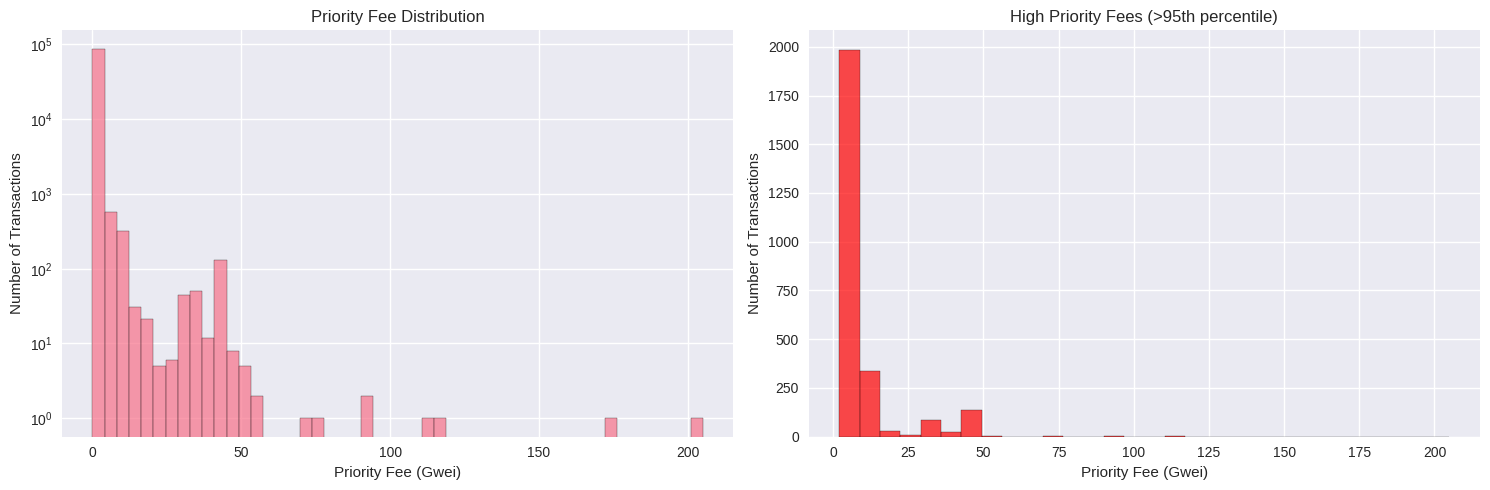

In [7]:
# 1. PRIORITY FEE ANALYSIS
print("=== PRIORITY FEE ANALYSIS ===")
# Count transactions with NaN priority fees
nan_priority_fee_count = df["max_priority_fee_per_gas"].isna().sum()
print(f"Transactions with NaN priority fees: {nan_priority_fee_count:,}")

priority_fee_txs = df[df["max_priority_fee_per_gas"].notna()].copy()

print(f"Transactions with priority fees: {len(priority_fee_txs):,}")

# Convert priority fees to Gwei for easier reading
priority_fee_txs["priority_fee_gwei"] = (
    priority_fee_txs["max_priority_fee_per_gas"] / 1e9
)

# Basic priority fee statistics
print(f"\n=== PRIORITY FEE STATS (Gwei) ===")
print(priority_fee_txs["priority_fee_gwei"].describe())

# Find extremely high priority fees (potential MEV competition)
high_priority_threshold = priority_fee_txs["priority_fee_gwei"].quantile(0.95)
high_priority_txs = priority_fee_txs[
    priority_fee_txs["priority_fee_gwei"] > high_priority_threshold
]

print(
    f"\nHigh priority fee transactions (>95th percentile, >{high_priority_threshold:.2f} Gwei): {len(high_priority_txs)}"
)
print(f"Max priority fee paid: {priority_fee_txs['priority_fee_gwei'].max():.2f} Gwei")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(priority_fee_txs["priority_fee_gwei"], bins=50, alpha=0.7, edgecolor="black")
ax1.set_xlabel("Priority Fee (Gwei)")
ax1.set_ylabel("Number of Transactions")
ax1.set_title("Priority Fee Distribution")
ax1.set_yscale("log")

ax2.hist(
    high_priority_txs["priority_fee_gwei"],
    bins=30,
    alpha=0.7,
    color="red",
    edgecolor="black",
)
ax2.set_xlabel("Priority Fee (Gwei)")
ax2.set_ylabel("Number of Transactions")
ax2.set_title(f"High Priority Fees (>95th percentile)")

plt.tight_layout()
plt.show()


=== BLOCK POSITION ANALYSIS ===


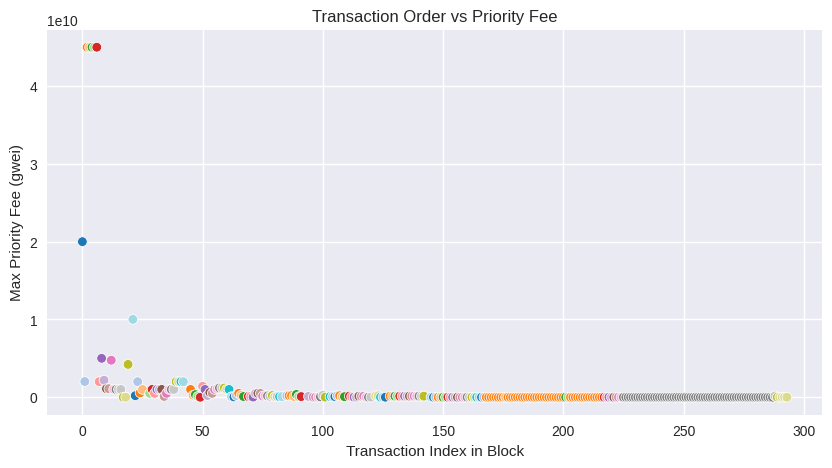

In [8]:
# 2. BLOCK POSITION vs PRIORITY FEE ANALYSIS
print("=== BLOCK POSITION ANALYSIS ===")


block_df = df[df["block_number"] == 23300000]

plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=block_df,
    x="transaction_index",
    y="max_priority_fee_per_gas",
    hue="from_address",
    palette="tab20",
)
plt.title("Transaction Order vs Priority Fee")
plt.xlabel("Transaction Index in Block")
plt.ylabel("Max Priority Fee (gwei)")
plt.legend([], [], frameon=False)
plt.show()


=== SANDWICH ATTACK DETECTION ===
Analyzing 501 blocks...
Potential sandwich attacks detected: 10

=== SANDWICH ATTACK EXAMPLES ===

Sandwich 1 in block 23300096:
  Attacker: 0xae2d4617c862309a3d75a0ffb358c7a5009c673f
  Front-run tx: 0x68c03a882fb98f97312c37cf8bfd9012030be903586b8175c8344a9b703c3db3 | Gas: 2000000000.0 | Value: 0.0 | Index: 10 | From → To: 0xae2d4617c862309a3d75a0ffb358c7a5009c673f → 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48
  Victim tx: 0x662c1cfa74ed7e4484d23c4aaaaba7aecb0a2d8a9423ab6418985d422783428c    | Gas: 2000000000.0 | Value: 0.0 | Index: 12 | From → To: 0x00d66ca0d809fff0a81d18f0d28a14ff308cbc5a → 0xdac17f958d2ee523a2206206994597c13d831ec7
  Back-run tx: 0xc59f57dcaac28dee51a2d493ac67a9e0a46f1f413920464ab60e842e1cea8c75  | Gas: 2000000000.0 | Value: 0.0 | Index: 13 | From → To: 0xae2d4617c862309a3d75a0ffb358c7a5009c673f → 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48

Sandwich 2 in block 23300120:
  Attacker: 0xae2d4617c862309a3d75a0ffb358c7a5009c673f
  Front-r

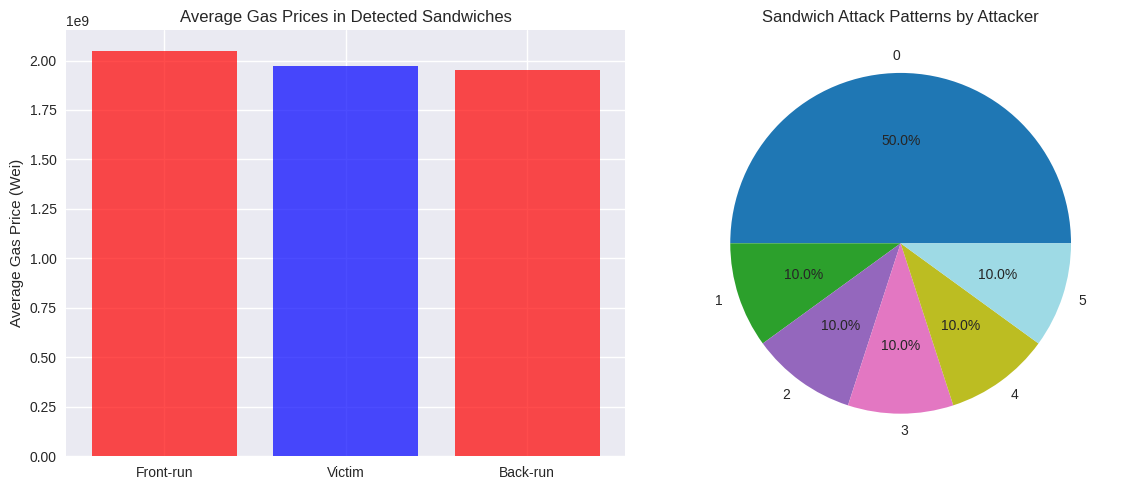

In [9]:
import matplotlib.cm as cm

print("=== SANDWICH ATTACK DETECTION ===")

df_filtered = df[
    (df["input"] != "0x")
    & (df["to_address"].notnull())
    & (df["max_priority_fee_per_gas"].notnull())
    & (df["max_priority_fee_per_gas"] > 0)
]


def find_sandwiches_strict(block_df, min_victim_value=0):
    sandwiches = []
    n = len(block_df)

    if n < 3:
        return sandwiches

    # Compute 90th percentile of gas prices in the block
    fee_90pct = block_df["max_priority_fee_per_gas"].quantile(0.9)

    for i in range(n - 2):  # only check 3 consecutive transactions
        front = block_df.iloc[i]
        victim = block_df.iloc[i + 1]  # middle transaction
        back = block_df.iloc[i + 2]

        # Skip if victim value too low or attacker is same as victim
        if (
            victim["value"] < min_victim_value
            or front["from_address"] == victim["from_address"]
        ):
            continue

        # Front-run conditions
        if front["max_priority_fee_per_gas"] < victim["max_priority_fee_per_gas"]:
            continue
        if back["max_priority_fee_per_gas"] > victim["max_priority_fee_per_gas"]:
            continue
        if (
            front["max_priority_fee_per_gas"] < fee_90pct
        ):  # must be in top 10% gas prices of block
            continue

        # Back-run conditions
        back_matches_attacker = (
            back["from_address"] == front["from_address"]
            or back["to_address"] == front["from_address"]
        )
        back_gas_ok = (
            abs(back["max_priority_fee_per_gas"] - victim["max_priority_fee_per_gas"])
            / victim["max_priority_fee_per_gas"]
            <= 0.1
        )  # ~10% tolerance

        if back_matches_attacker and back_gas_ok:
            sandwiches.append(
                {
                    "block_number": victim["block_number"],
                    "front_transaction_index": front["transaction_index"],
                    "victim_transaction_index": victim["transaction_index"],
                    "back_transaction_index": back["transaction_index"],
                    "attacker": front["from_address"],
                    "victim": victim["from_address"],
                    "front_tx": front["hash"],
                    "victim_tx": victim["hash"],
                    "back_tx": back["hash"],
                    "front_from": front["from_address"],
                    "front_to": front["to_address"],
                    "victim_from": victim["from_address"],
                    "victim_to": victim["to_address"],
                    "back_from": back["from_address"],
                    "back_to": back["to_address"],
                    "front_tip_gas_price": front["max_priority_fee_per_gas"],
                    "victim_tip_gas_price": victim["max_priority_fee_per_gas"],
                    "back_tip_gas_price": back["max_priority_fee_per_gas"],
                    "front_value": front["value"],
                    "victim_value": victim["value"],
                    "back_value": back["value"],
                }
            )
    return sandwiches


all_sandwiches = []
blocks_to_analyze = df_filtered["block_number"].unique()

print(f"Analyzing {len(blocks_to_analyze)} blocks...")

for block_num in blocks_to_analyze:
    block_txs = (
        df_filtered[df_filtered["block_number"] == block_num]
        .sort_values("transaction_index")
        .reset_index(drop=True)
    )
    sandwiches = find_sandwiches_strict(block_txs)
    all_sandwiches.extend(sandwiches)

print(f"Potential sandwich attacks detected: {len(all_sandwiches)}")

if all_sandwiches:
    sandwich_df = pd.DataFrame(all_sandwiches)
    print("\n=== SANDWICH ATTACK EXAMPLES ===")
    for i, s in enumerate(all_sandwiches[:]):
        print(f"\nSandwich {i + 1} in block {s['block_number']}:")
        print(f"  Attacker: {s['attacker']}")
        print(
            f"  Front-run tx: {s['front_tx']} | Gas: {s['front_tip_gas_price']} | Value: {s['front_value']} | Index: {s['front_transaction_index']} | From → To: {s['front_from']} → {s['front_to']}"
        )
        print(
            f"  Victim tx: {s['victim_tx']}    | Gas: {s['victim_tip_gas_price']} | Value: {s['victim_value']} | Index: {s['victim_transaction_index']} | From → To: {s['victim_from']} → {s['victim_to']}"
        )
        print(
            f"  Back-run tx: {s['back_tx']}  | Gas: {s['back_tip_gas_price']} | Value: {s['back_value']} | Index: {s['back_transaction_index']} | From → To: {s['back_from']} → {s['back_to']}"
        )

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    x = ["Front-run", "Victim", "Back-run"]
    mean_gas_prices = [
        sandwich_df["front_tip_gas_price"].mean(),
        sandwich_df["victim_tip_gas_price"].mean(),
        sandwich_df["back_tip_gas_price"].mean(),
    ]
    plt.bar(x, mean_gas_prices, alpha=0.7, color=["red", "blue", "red"])
    plt.ylabel("Average Gas Price (Wei)")
    plt.title("Average Gas Prices in Detected Sandwiches")

    plt.subplot(1, 2, 2)

    attackers = sandwich_df["attacker"].unique()
    sizes = [len(sandwich_df[sandwich_df["attacker"] == a]) for a in attackers]

    colors = cm.tab20(np.linspace(0, 1, len(attackers)))
    labels = [str(i) for i in range(len(attackers))]

    plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors)
    plt.title("Sandwich Attack Patterns by Attacker")

    plt.tight_layout()
    plt.show()
else:
    print("No clear sandwich patterns detected with current criteria.")


In [10]:
# 5. MEV BOT IDENTIFICATION - Finding Consistent High-Fee Addresses
print("=== MEV BOT IDENTIFICATION ===")
# Get top 10% gas threshold across all df_filtered
global_fee_90pct = df_filtered["max_priority_fee_per_gas"].quantile(0.9)

attackers = sandwich_df["attacker"].unique()
stats_list = []

for attacker in attackers:
    attacker_txs = df_filtered[df_filtered["from_address"] == attacker]
    attacker_sandwiches = sandwich_df[sandwich_df["attacker"] == attacker]

    total_txs = len(attacker_txs)
    high_gas_txs = (attacker_txs["max_priority_fee_per_gas"] >= global_fee_90pct).sum()
    sandwiches_count = len(attacker_sandwiches)
    avg_gas = attacker_txs["max_priority_fee_per_gas"].mean()
    avg_value = attacker_txs["value"].mean()

    stats_list.append(
        {
            "attacker": attacker,
            "total_transactions": total_txs,
            "high_gas_transactions": high_gas_txs,
            "sandwiches_detected": sandwiches_count,
            "avg_gas_price": avg_gas,
            "avg_tx_value": avg_value,
        }
    )

attacker_stats_df = pd.DataFrame(stats_list).sort_values(
    by=["sandwiches_detected", "high_gas_transactions"], ascending=False
)

print(attacker_stats_df)


=== MEV BOT IDENTIFICATION ===
                                     attacker  total_transactions  \
0  0xae2d4617c862309a3d75a0ffb358c7a5009c673f                 162   
5  0x89e51fa8ca5d66cd220baed62ed01e8951aa7c40                 158   
1  0x65a8f07bd9a8598e1b5b6c0a88f4779dbc077675                  23   
2  0x453aaa56db032fc3b3aa9934165d0ba1a6b7ddd0                   4   
3  0xe0bb449bb115dbc335aa1ed348b30fffa666c37a                   3   
4  0xe2d6ae60244376c311cd4f54a8455ed18977134a                   2   

   high_gas_transactions  sandwiches_detected  avg_gas_price  avg_tx_value  
0                    162                    5   2.000000e+09  0.000000e+00  
5                    158                    1   2.000000e+09  0.000000e+00  
1                      9                    1   1.422565e+09  2.525485e+16  
2                      4                    1   1.500000e+09  1.600000e+16  
3                      3                    1   2.000000e+09  0.000000e+00  
4                      

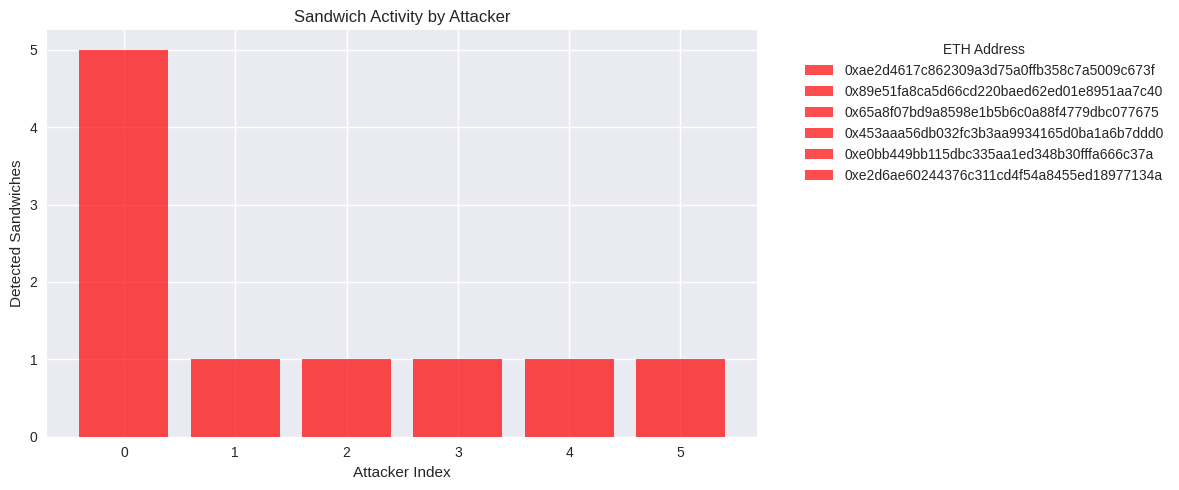

Index → ETH Address mapping:
0 → 0xae2d4617c862309a3d75a0ffb358c7a5009c673f
1 → 0x89e51fa8ca5d66cd220baed62ed01e8951aa7c40
2 → 0x65a8f07bd9a8598e1b5b6c0a88f4779dbc077675
3 → 0x453aaa56db032fc3b3aa9934165d0ba1a6b7ddd0
4 → 0xe0bb449bb115dbc335aa1ed348b30fffa666c37a
5 → 0xe2d6ae60244376c311cd4f54a8455ed18977134a


In [11]:
x = np.arange(len(attacker_stats_df))
y = attacker_stats_df["sandwiches_detected"]

plt.figure(figsize=(12, 5))
bars = plt.bar(x, y, color="red", alpha=0.7)

# Add legend with ETH addresses
plt.legend(
    bars,
    attacker_stats_df["attacker"],
    title="ETH Address",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

plt.xticks(x, x)  # Show indexes on x-axis
plt.ylabel("Detected Sandwiches")
plt.xlabel("Attacker Index")
plt.title("Sandwich Activity by Attacker")
plt.tight_layout()
plt.show()

print("Index → ETH Address mapping:")
for idx, addr in enumerate(attacker_stats_df["attacker"]):
    print(f"{idx} → {addr}")
